# POS tagger with CNN

In [22]:
import nltk

Get the tokenized and tagged with Universal POS sentences from the "news" category from the Brown corpus:

In [23]:
from nltk.corpus import brown
nltk.download('universal_tagset')
brown_sents = brown.tagged_sents(categories='news', tagset='universal')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/medialab/attardi/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


## Split into train and test
Use all but the last 1000 sentences to train the classifier. (It should be better to choose them randomly).

In [24]:
brown_train = brown_sents[:-1000]
brown_test = brown_sents[-1000:]

## Build dictionary of words and tags

Vocabularies of words and tags:

In [25]:
word_set = set()
tag_set = set()
for sentence in brown_sents:
    for word, tag in sentence:
        word_set.add(word)
        tag_set.add(tag)

Dictionaries of words and tags:

In [26]:
word_index = {word: idx + 2 for idx, word in enumerate(word_set)} # + 2 leave 0 and 1 for padding and unknown
    
tag_index = {tag: idx for idx,tag in enumerate(tag_set)}
idx2tag = list(tag_set)

n_words = len(word_index) + 2 # for padding and OOV
n_tags = len(tag_set)

In [27]:
unknown_idx = 1
x_train_cnn = [[word_index.get(word, word_index.get(word.lower(), unknown_idx))
            for word,tag in sentence] for sentence in brown_train]
y_train_cnn = [[tag_index[tag] for word,tag in sentence]
                                       for sentence in brown_train]
x_test_cnn = [[word_index.get(word, word_index.get(word.lower(), unknown_idx))
                    for word,tag in sentence] for sentence in brown_test]
y_test_cnn = [[tag_index[tag] for word,tag in sentence]
                                       for sentence in brown_test]

y_test = [tag_index[t] for sent in brown_test for w,t in sent]

In [28]:
MAX_SEQUENCE_LENGTH = 250
HIDDEN_SIZE = 128
EMBEDDING_DIM = 50
EPOCHS = 4
BATCH_SIZE = 64

In [29]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

tag_pad = n_tags # use this value to distinguish pad in tags

x_train_cnn = pad_sequences(x_train_cnn, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
x_test_cnn = pad_sequences(x_test_cnn, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
y_train_cnn = pad_sequences(y_train_cnn, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post',
                          value=tag_pad)
y_test_cnn = pad_sequences(y_test_cnn, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post',
                          value=tag_pad)

In [30]:
from tensorflow.keras.utils import to_categorical
y_train_cnn_cat = to_categorical(y_train_cnn, num_classes=n_tags+1)

### Build the model

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Conv1D
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.losses import categorical_crossentropy

In [32]:
window_size = 5
filters = 250

model_cnn = Sequential()
model_cnn.add(Embedding(n_words, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_cnn.add(Conv1D(filters, window_size, padding='same', activation='relu'))
model_cnn.add(Dense(HIDDEN_SIZE, activation='relu'))
model_cnn.add(Dropout(0.2)) # optional
model_cnn.add(Dense(n_tags+1, activation='softmax'))
model_cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

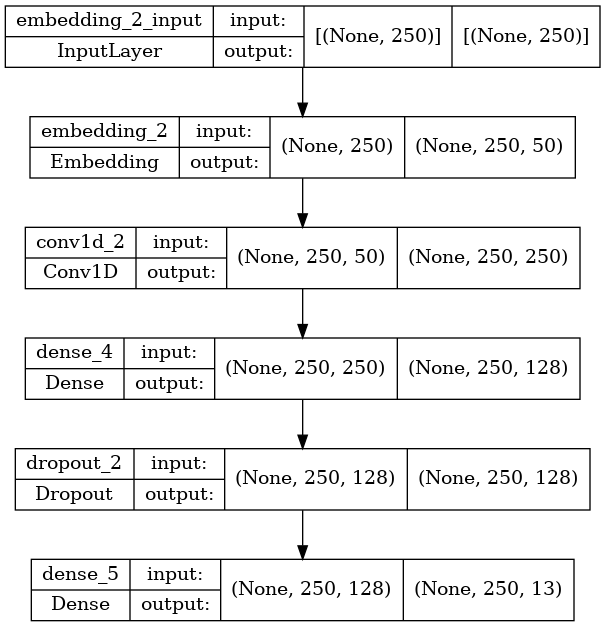

In [33]:
from tensorflow.keras.utils import plot_model
plot_model(model_cnn, show_shapes=True)

In [34]:
history = model_cnn.fit(x_train_cnn, y_train_cnn_cat, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/4
57/57 [==============================] - 5s 82ms/step - loss: 0.6750 - accuracy: 0.9246
Epoch 2/4
57/57 [==============================] - 5s 83ms/step - loss: 0.0832 - accuracy: 0.9773
Epoch 3/4
57/57 [==============================] - 5s 83ms/step - loss: 0.0327 - accuracy: 0.9908
Epoch 4/4
57/57 [==============================] - 5s 83ms/step - loss: 0.0125 - accuracy: 0.9969


In [35]:
tag_pred_cnn = model_cnn.predict(x_test_cnn)
y_pred_cnn = tag_pred_cnn.argmax(2)

Remove pads:

In [36]:
y_pred_cnn = [[pred[i] for i,t in enumerate(gold) if t != tag_pad] for gold,pred in zip(y_test_cnn,y_pred_cnn)]
y_pred_cnn_flat = [item for sublist in y_pred_cnn for item in sublist]

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def show_accuracy(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred) * 100
    pr = precision_score(y_test, y_pred, average='macro', zero_division=0) * 100
    rc = recall_score(y_test, y_pred, average='macro', zero_division=0) * 100
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0) * 100
    print("Accuracy: %.2f, Precision: %.2f, Recall: %.2f, F1: %.2f" %
          (acc, pr, rc, f1))

In [38]:
show_accuracy(y_test, y_pred_cnn_flat)

Accuracy: 92.41, Precision: 78.94, Recall: 75.85, F1: 77.22


# BiLSTM

In [39]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import add
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda

- Embedding layer : We will specify the maximum length (50) of the padded sequences. After the network is trained, the embedding layer will transform each token into a vector of n dimensions.
- Bidirectional LSTM: Bidirectional lstm takes a recurrent layer (e.g. the first LSTM layer) as an argument. This layer takes the output from the previous embedding layer . We will use 2 Bi LSTM layers and residual connection to the first biLSTM
- TimeDistributed Layer: We are dealing with Many to Many RNN Architecture, where we expect output from every input sequence. Here is an example, in the sequence (a1 →b1, a2 →b2…an →bn), a, and b are inputs and outputs of every sequence. The TimeDistributeDense layers allow Dense(fully-connected) operation across every output over every time-step. Not using this layer will result in a single final output.

In [ ]:
input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

In [ ]:
tag_model = Model(input_text, out)
tag_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(tag_model,'Elmo_tag.png',show_shapes= True)

In [ ]:
history = tag_model.fit(np.array(X_tr), y_tr, validation_data=(np.array(X_val), y_val),
                    batch_size=batch_size, epochs=1, verbose=1)

In [ ]:
test_pred = tag_model.predict(np.array(X_te), verbose=1)

In [ ]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = test2label(y_te[:149*32])